# Fastdup Tutorial

[Visit our GitHub Project Page](https://github.com/visualdatabase/fastdup)

## Install fastdup

In [ ]:
!pip install fastdup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 1.3 MB/s 


In [ ]:
import fastdup

In [ ]:
fastdup.__version__

'0.65'

## Download the food-101 dataset

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2022-06-11 13:42:37--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2022-06-11 13:42:37--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  27.2MB/s    in 3m 3s   

2022-06-11 13:45:41 (26.1 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [ ]:
!tar xzf food-101.tar.gz

Streaming output truncated to the last 5000 lines.
food-101/images/edamame/1828743.jpg
food-101/images/edamame/3421283.jpg
food-101/images/edamame/3101228.jpg
food-101/images/edamame/2518418.jpg
food-101/images/edamame/1538978.jpg
food-101/images/edamame/2534828.jpg
food-101/images/edamame/91319.jpg
food-101/images/edamame/1622192.jpg
food-101/images/edamame/3243136.jpg
food-101/images/edamame/2151578.jpg
food-101/images/edamame/1341540.jpg
food-101/images/edamame/442760.jpg
food-101/images/edamame/3156052.jpg
food-101/images/edamame/759609.jpg
food-101/images/edamame/1945493.jpg
food-101/images/edamame/503407.jpg
food-101/images/edamame/3679400.jpg
food-101/images/edamame/2502946.jpg
food-101/images/edamame/97859.jpg
food-101/images/edamame/2946074.jpg
food-101/images/edamame/579608.jpg
food-101/images/edamame/113525.jpg
food-101/images/edamame/663487.jpg
food-101/images/edamame/3869100.jpg
food-101/images/edamame/3253578.jpg
food-101/images/edamame/3803786.jpg
food-101/images/edamame

## Run fastdup to gain insights from your data

In [ ]:
fastdup.run('food-101')

In [ ]:
fastdup.create_duplicates_gallery('similarity.csv',save_path='.', num_images=20)

100%|██████████| 20/20 [00:00<00:00, 41.47it/s]


Stored similarity visual view in  ./similarity.html



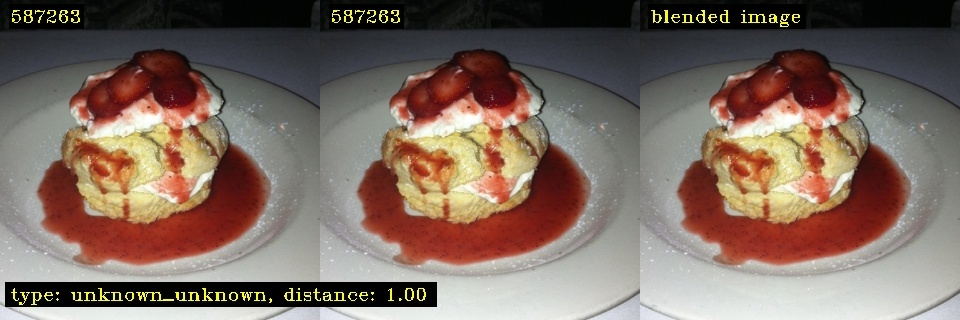
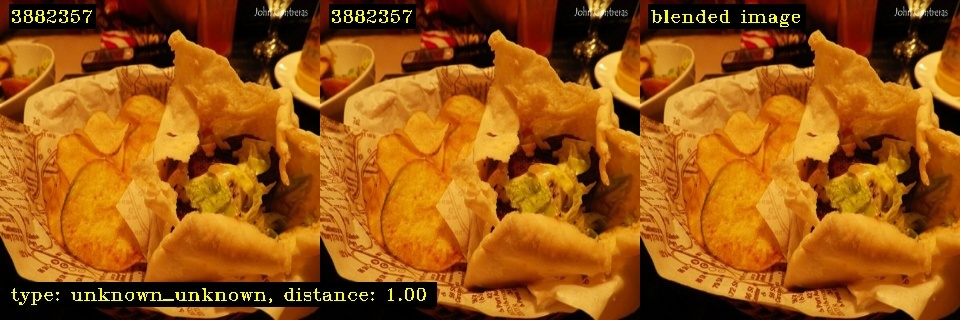
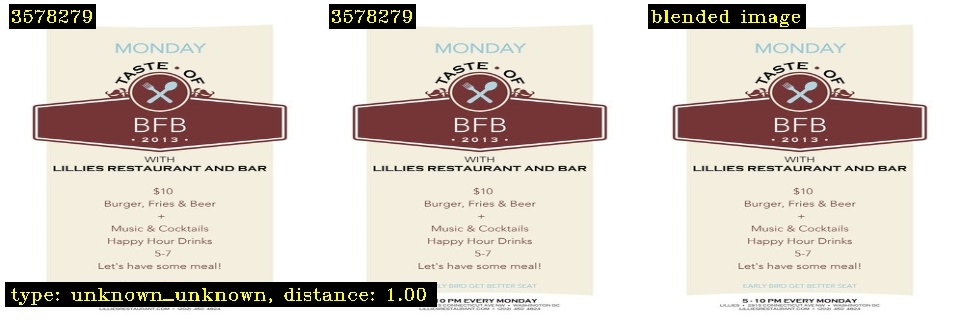
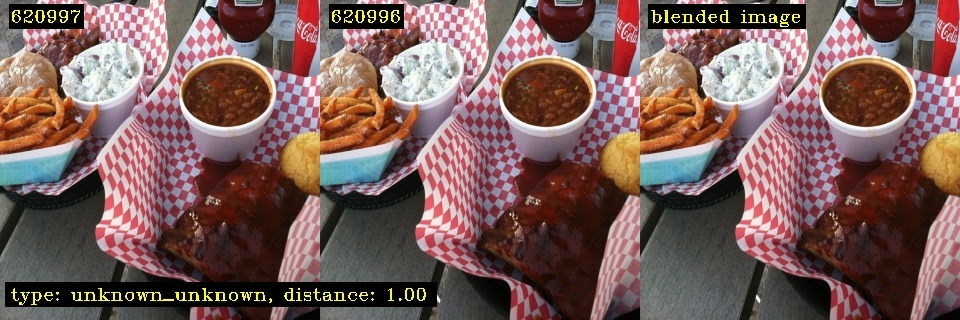
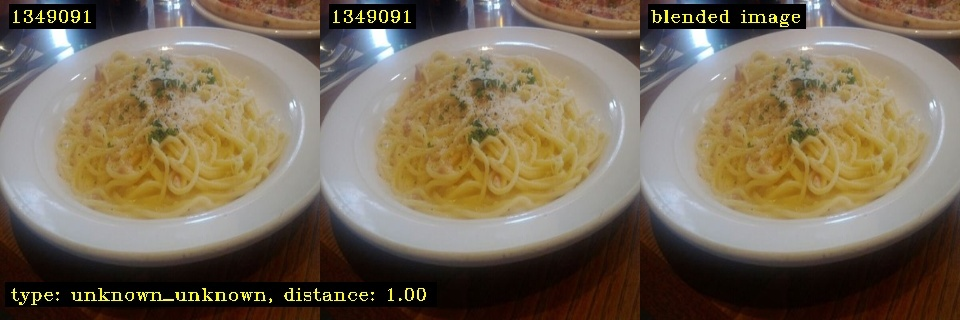
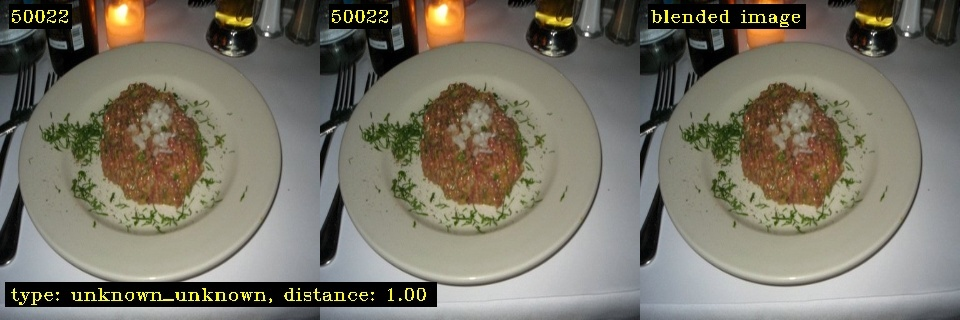
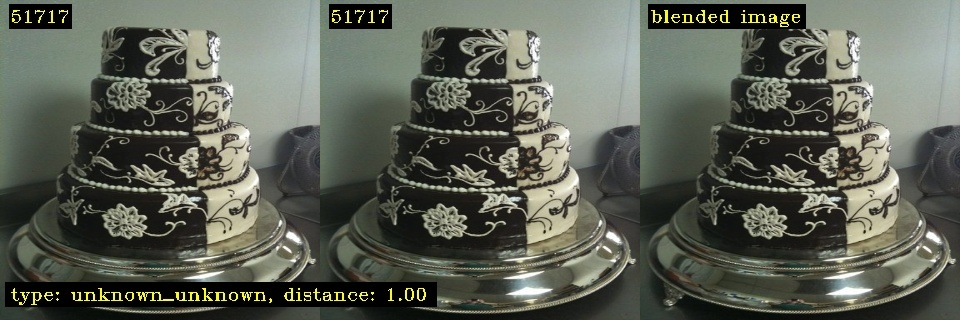
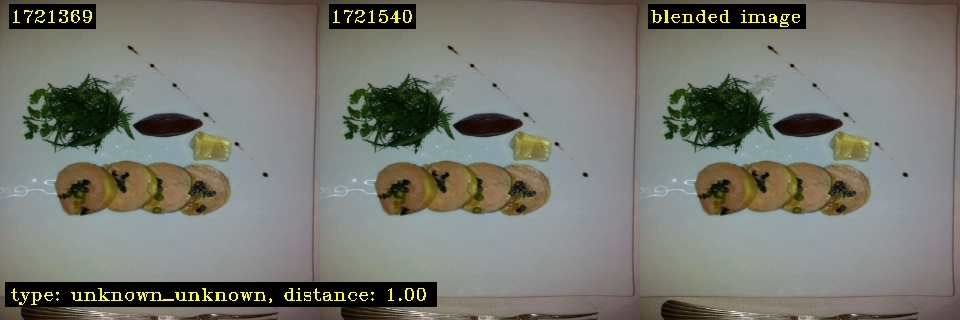
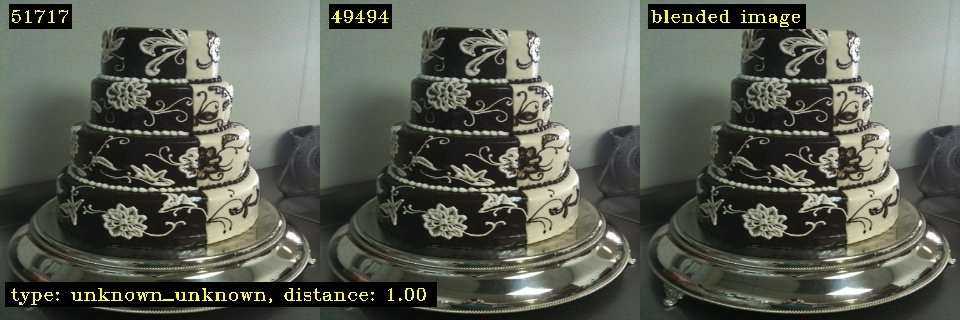
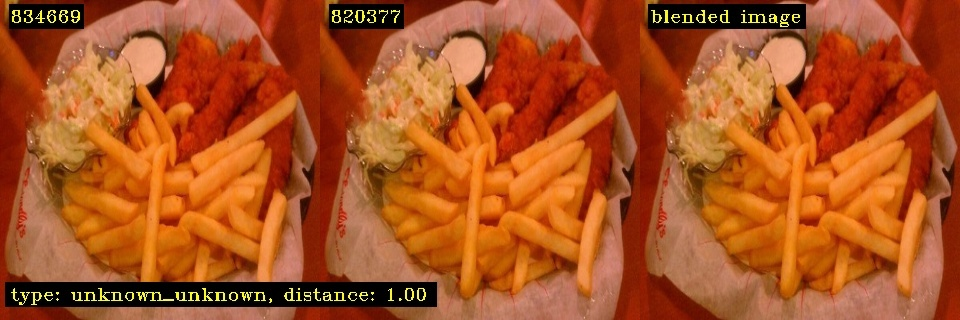
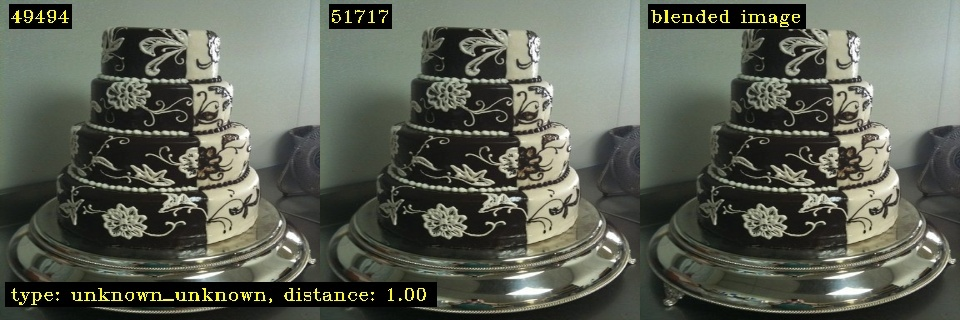
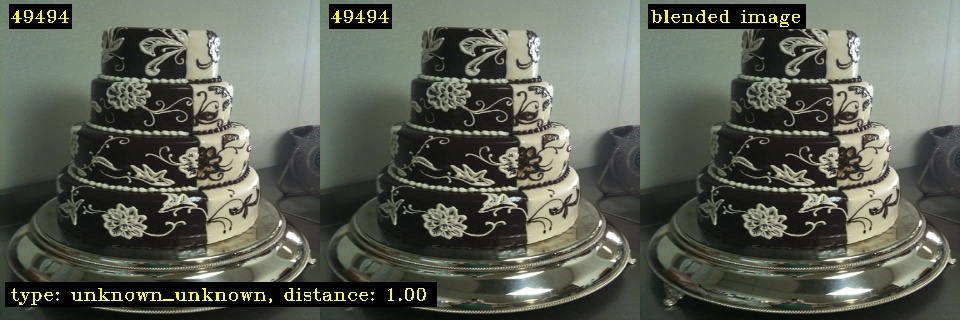
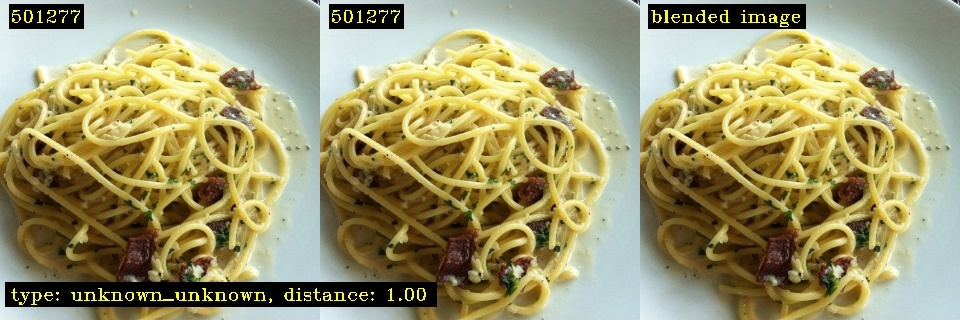
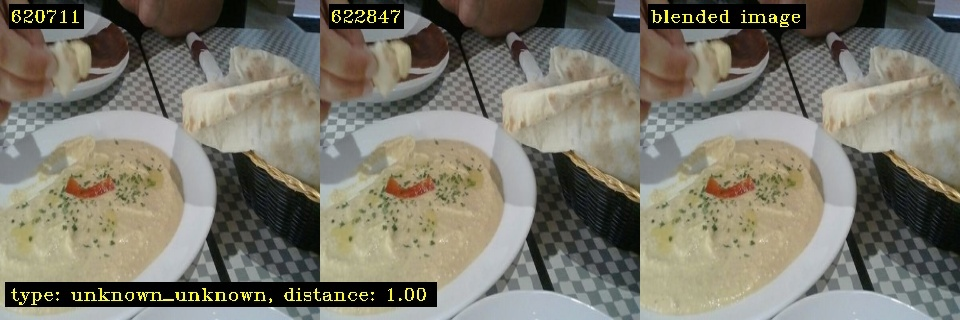
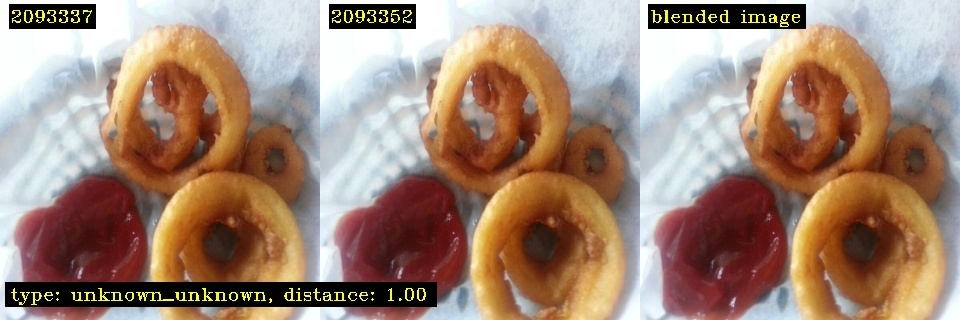
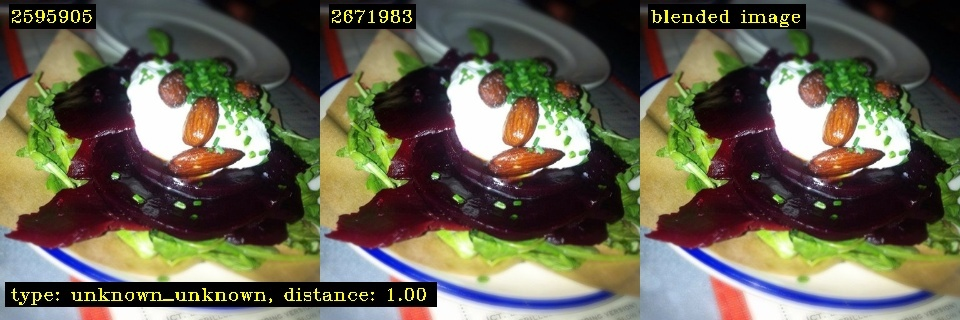
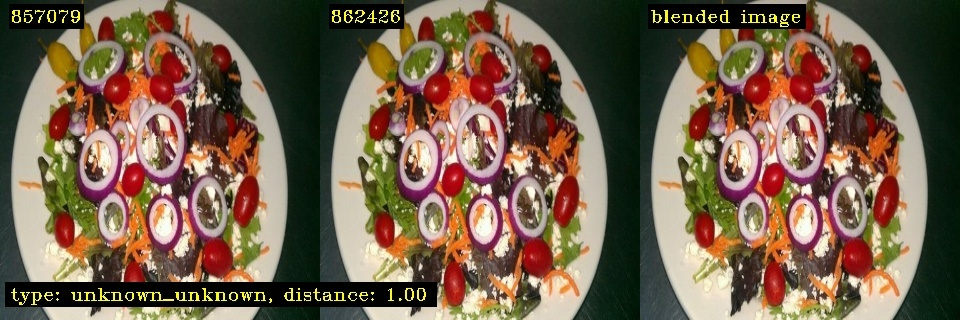
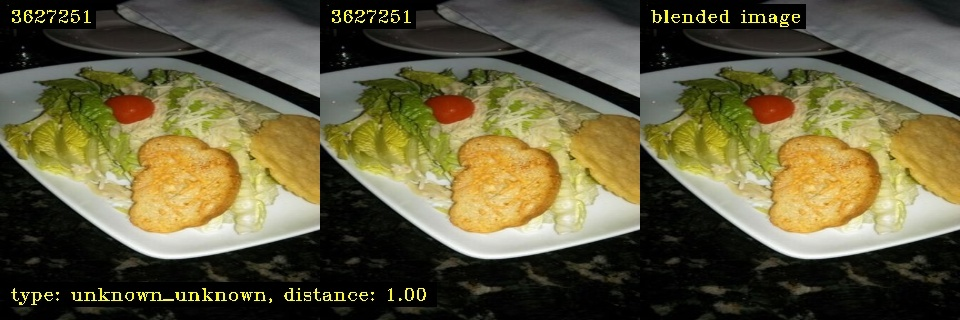
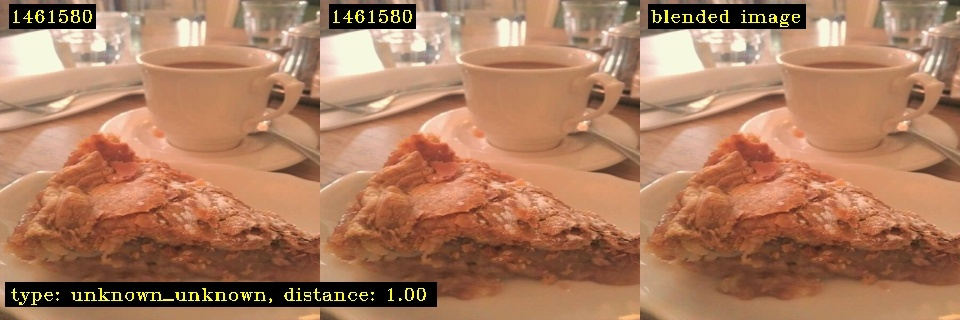
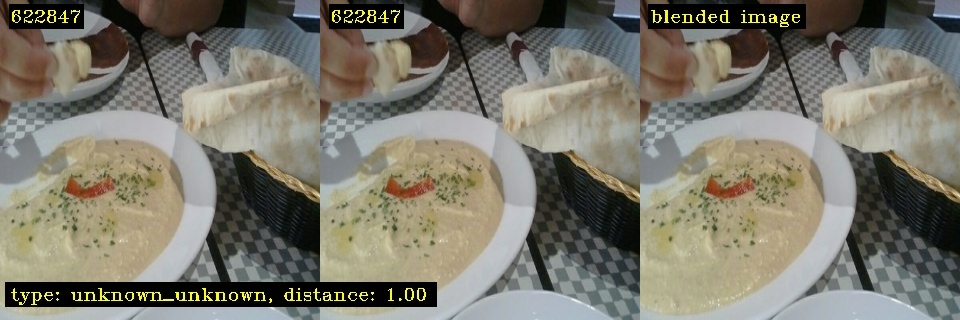

In [ ]:
from IPython.display import HTML
HTML('similarity.html')

In [ ]:
fastdup.create_outliers_gallery('outliers.csv',save_path='.', num_images=20)

100%|██████████| 20/20 [00:00<00:00, 112.80it/s]


Stored outliers visual view in  ./outliers.html



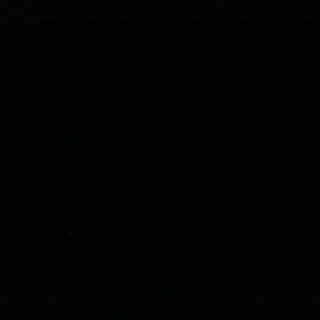
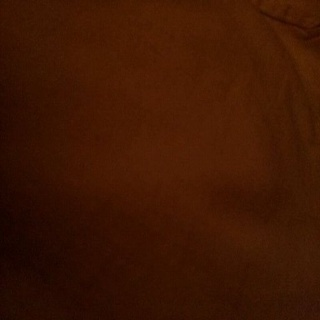
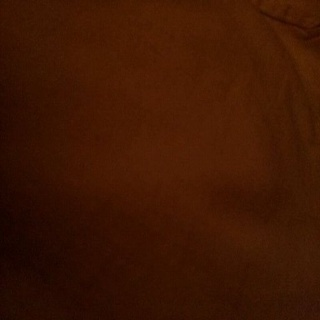
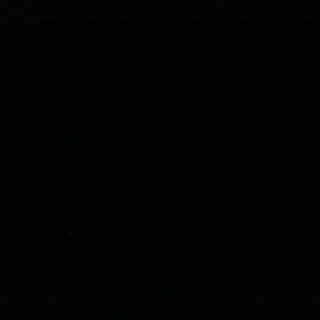
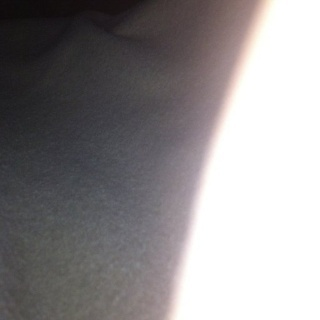
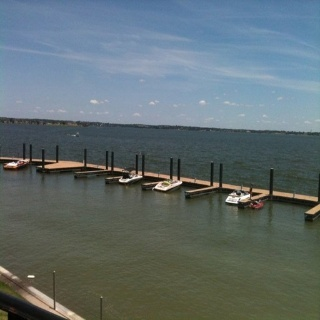
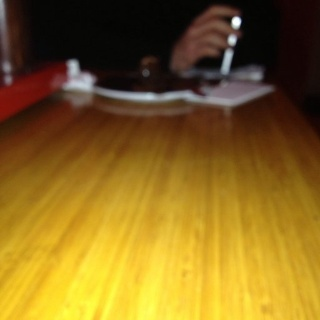
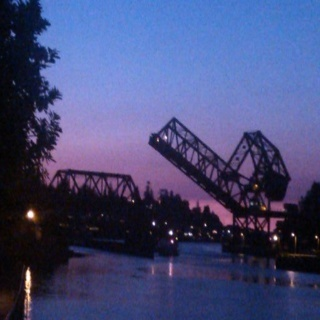
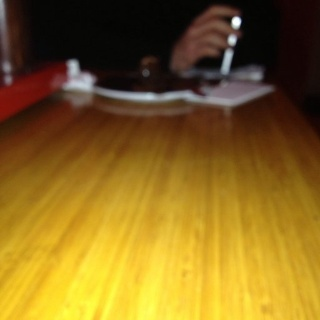
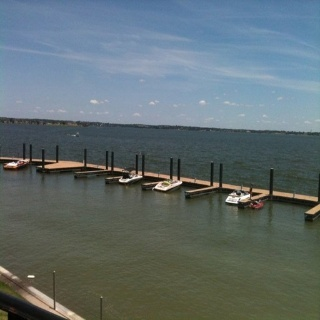
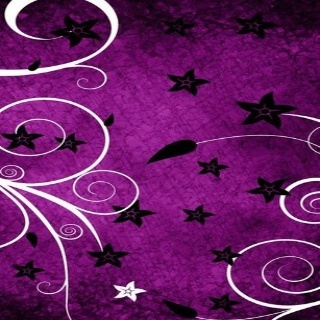
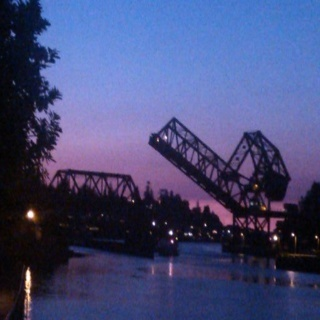
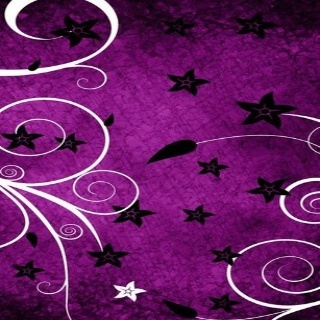
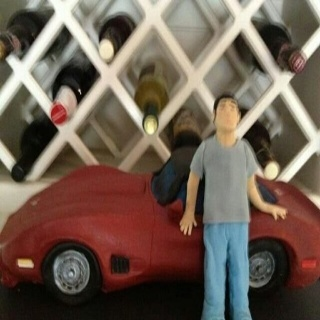
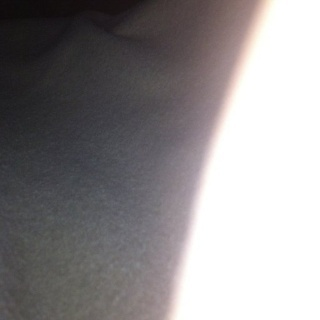
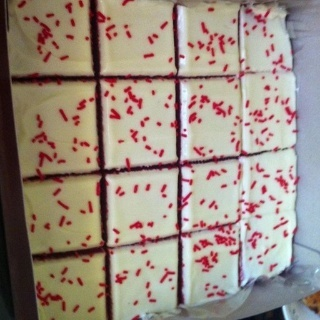
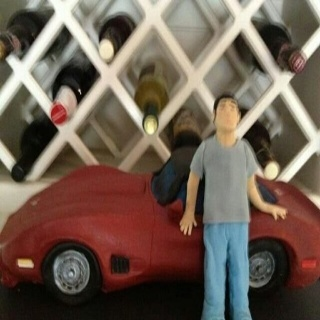
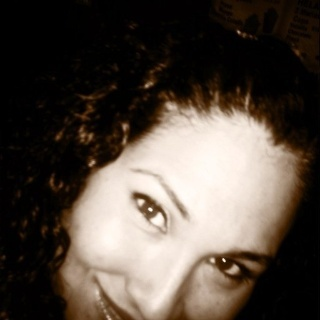
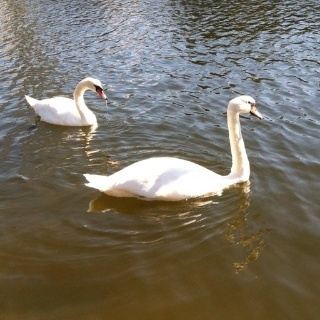
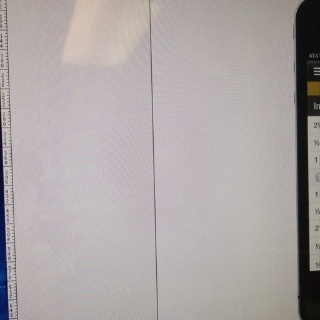

In [ ]:
HTML('outliers.html')

## Perform graph analytics to find connected components of images

Connected components are clusters of similar images. In the code below we find the largest clusters of duplicate images and visualize them.

In [ ]:
import pandas as pd
# read fastdup connected components, for each image id we get component id
components = pd.read_csv('connected_components.csv')
# read fastdup image file list. For each id we get image name
filenames = pd.read_csv('features.dat.csv')
assert len(components) == len(filenames)
# now join the two tables to get both id and image name
components['filename'] = filenames['filename']
components.head(5)

__id  component_id  pagerank  delta                               filename
0     0         32160      0.15    0.0  food-101/images/escargots/3821272.jpg
1     1         86097      0.15    0.0  food-101/images/escargots/3103402.jpg
2     2         43674      0.15    0.0  food-101/images/escargots/1896492.jpg
3     3         73432      0.15    0.0  food-101/images/escargots/1173428.jpg
4     4         97044      0.15    0.0  food-101/images/escargots/3286650.jpg

In [45]:
# find the components that have the largest number of images included
top_components = components.groupby('component_id').agg('count')[['__id']].sort_values('__id', ascending=False).reset_index()
top_components.head()

component_id  __id
0          9551     3
1         70594     3
2         64686     3
3          7175     2
4         14069     2

In [58]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from IPython.display import Image
import traceback

In [56]:

NUM_COMPONENTS_TO_PLOT = 5
MAX_IMAGES_IN_GRID = 48

# iterate over the top components
for i in range(0,NUM_COMPONENTS_TO_PLOT):
    try:
        # find the component id
        component_id = top_components['component_id'].values[i]
        # find all the image filenames linked to this id
        files = components[components['component_id'] == component_id]['filename'].values[:MAX_IMAGES_IN_GRID]

        fig = plt.figure(figsize=(10,8))
        images = []
        for f in files:
            img = PILImage.open(f).convert('RGB').resize((300,300))
            transform = transforms.Compose([transforms.PILToTensor()])
            tensor = transform(img)
            images.append(tensor)

        # make a grid image of all components
        grid = make_grid(images, nrow=12, padding=3)
        plt.imshow(np.transpose(grid, (1, 2, 0)), interpolation='nearest')
     
        # plot the image
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        plt.title('Components ' + str(i) + "\n" + str([os.path.basename(x) for x in files]))
        plt.savefig('component' + str(i) + '.png', bbox_inches='tight', pad_inches=0.1)
        plt.close(fig)
        plt.clf() 
        
    except Exception as ex:
        print('Failed on component', i, ex)
        traceback.print_exc()
    

<Figure size 432x288 with 0 Axes>

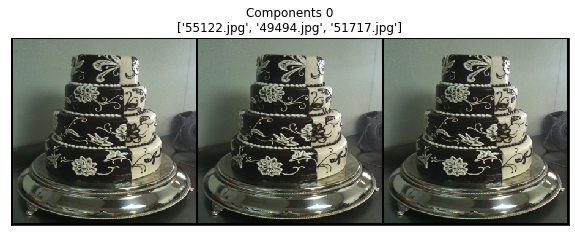

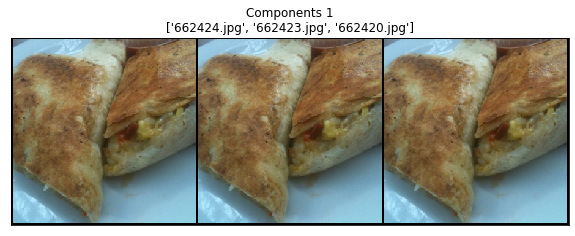

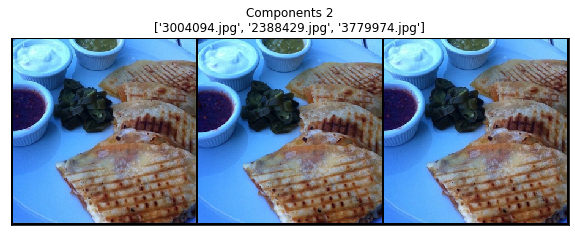

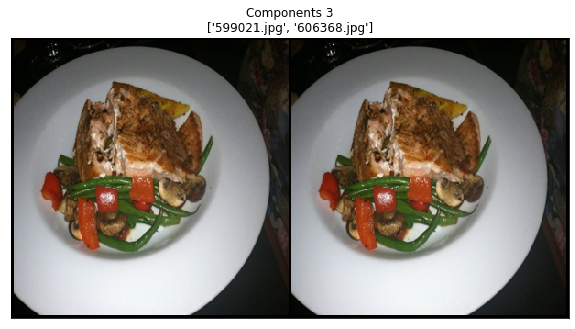

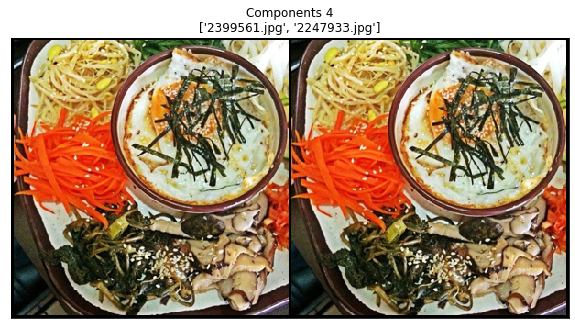

In [59]:
# displaay top components
for i in range(NUM_COMPONENTS_TO_PLOT):
  display(Image(filename=f'component{i}.png'))